# Drift analysis of PMID26623667

Tong Shu Li

We look at the drift for the filtered transcriptome only.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from scipy.stats import linregress

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_multi_density

In [4]:
%matplotlib inline

---

## Read filtered transcriptome

In [5]:
data = pd.read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(391644, 13)

In [7]:
data.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbaseid,gene_symbol
0,2RSSE.1,11,4.55942,1,1,1,water,0,1,4.105726,0.104814,WBGene00007064,2RSSE.1
1,2RSSE.1,12,3.21332,1,2,1,water,0,1,4.105726,-0.245078,WBGene00007064,2RSSE.1
2,2RSSE.1,13,4.54444,1,3,1,water,0,1,4.105726,0.101521,WBGene00007064,2RSSE.1
3,2RSSE.1,21,11.43680,2,1,3,water,0,1,4.105726,1.024454,WBGene00007064,2RSSE.1
4,2RSSE.1,22,4.77467,2,2,3,water,0,1,4.105726,0.150942,WBGene00007064,2RSSE.1


In [8]:
data["seqname"].nunique()

10879

In [9]:
data["log_cpm"] = np.log(data["cpm_value"])
data["ref_log_cpm"] = np.log(data["youngref_cpm"])

---

## Plot CPM distribution

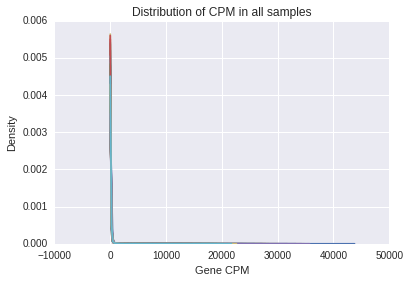

In [10]:
ax = plot_multi_density(
    data, ["cohort", "replicate"], "cpm_value"
)

ax.legend().set_visible(False)
ax.set_title("Distribution of CPM in all samples")
ax.set_xlabel("Gene CPM");

The raw CPMs need to be log normalized.

### Distribution of log CPM for all relevant samples

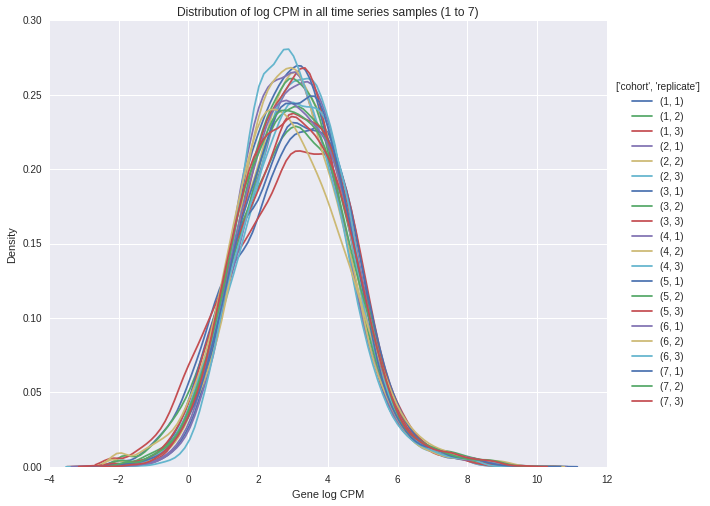

In [11]:
ax = plot_multi_density(
    data.query("cohort <= 7"), ["cohort", "replicate"], "log_cpm",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Distribution of log CPM in all time series samples (1 to 7)")
ax.set_xlabel("Gene log CPM");

I think these log CPM distributions aren't perfect but are good enough that I don't need to remove any of them.

## Distribution of RLFEC

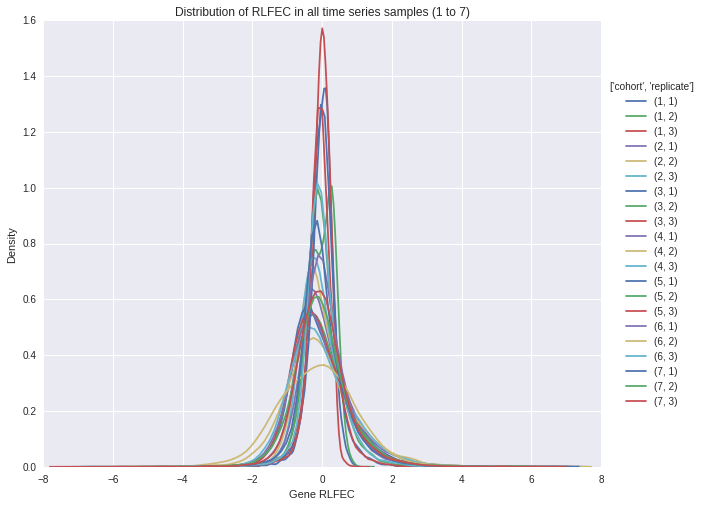

In [12]:
ax = plot_multi_density(
    data.query("cohort <= 7"), ["cohort", "replicate"], "RLFEC",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Distribution of RLFEC in all time series samples (1 to 7)")
ax.set_xlabel("Gene RLFEC");

Looks like sample 6, replicate 2 is very different from all the other samples. We will probably need to remove it.

---

## Calculate drift

In [13]:
drift = (
    data.groupby(
        [
            "cohort", "replicate", "samples", "day_harvested",
            "drug", "drug_conc_uM", "day_drug_added"
        ],
        as_index = False
    )
        .agg({"RLFEC": np.var})
        .rename(columns = {"RLFEC": "drift"})
        .sort_values(["cohort", "replicate"])
)

In [14]:
drift

,cohort,replicate,samples,day_harvested,drug,drug_conc_uM,day_drug_added,drift
0,1,1,11,1,water,0,1,0.105572
1,1,2,12,1,water,0,1,0.176070
2,1,3,13,1,water,0,1,0.123187
3,2,1,21,3,water,0,1,0.659756
4,2,2,22,3,water,0,1,0.562372
5,2,3,23,3,water,0,1,0.522795
6,3,1,31,5,water,0,1,0.776546
7,3,2,32,5,water,0,1,0.779723
8,3,3,33,5,water,0,1,0.743515
9,4,1,41,10,water,0,1,0.857668


In [15]:
drift["log_day"] = np.log(drift["day_harvested"])

## Plot drift (linear model, no outliers removed)

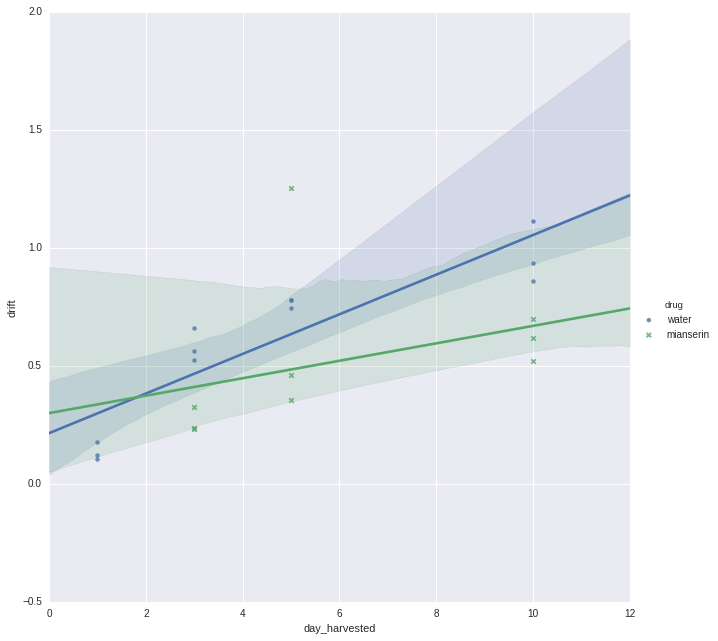

In [16]:
sns.lmplot(
    data = drift.query("cohort <= 7"),
    x = "day_harvested", y = "drift",
    hue = "drug", size = 9, markers = ['o', 'x']
);

Now that we are plotting individual samples as single numbers, it is much easier to see that sample 6, replicate 2 (day 5 harvest) is very different from the rest of the mianserin samples on day 5. We will remove it and replot.

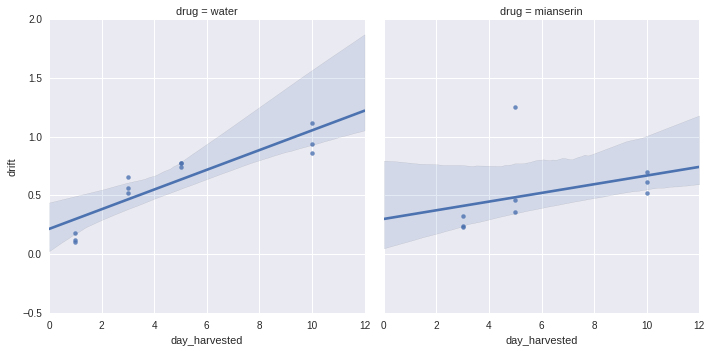

In [17]:
sns.lmplot(
    data = drift.query("cohort <= 7"),
    x = "day_harvested", y = "drift",
    col = "drug"
);

## Drift without sample 6, replicate 2 (mianserin day 5) (linear model)

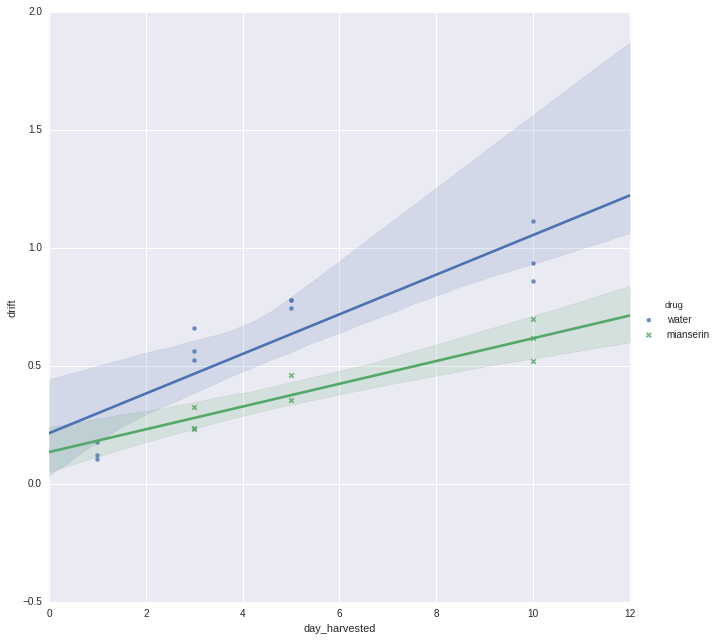

In [18]:
sns.lmplot(
    data = drift.query("cohort <= 7 & samples != 62"),
    x = "day_harvested", y = "drift",
    hue = "drug", size = 9, markers = ['o', 'x']
);

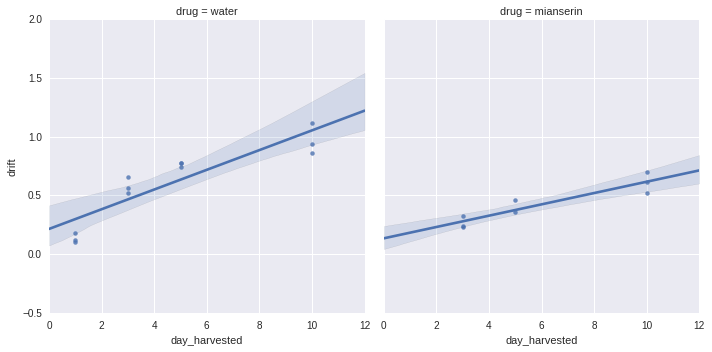

In [19]:
sns.lmplot(
    data = drift.query("cohort <= 7 & samples != 62"),
    x = "day_harvested", y = "drift",
    col = "drug"
);

### Pearson coefficients

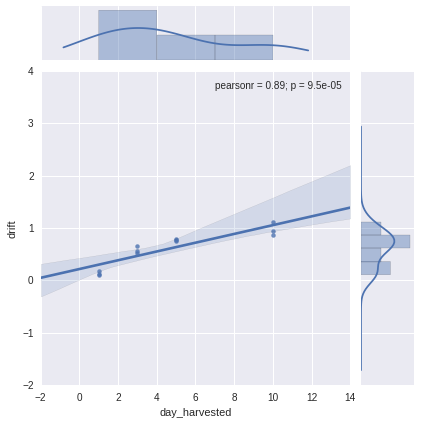

In [20]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'water'"),
    x = "day_harvested", y = "drift",
    kind = "reg"
);

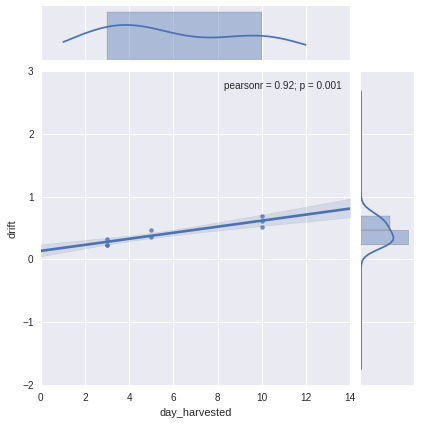

In [21]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'mianserin'"),
    x = "day_harvested", y = "drift",
    kind = "reg"
);

### Residuals

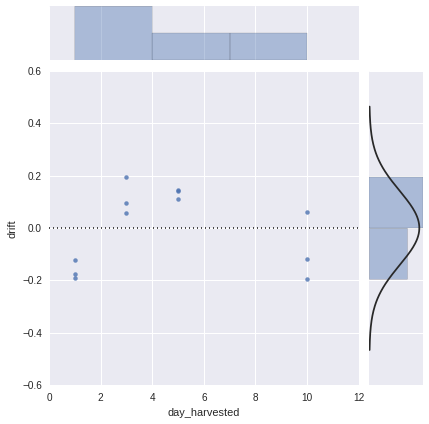

In [22]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'water'"),
    x = "day_harvested", y = "drift",
    kind = "resid"
);

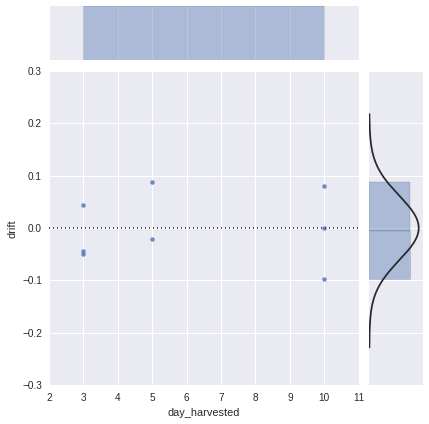

In [23]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'mianserin'"),
    x = "day_harvested", y = "drift",
    kind = "resid"
);

After removing sample 6 replicate 2, we see that the mianserin data follows a very nice linear relationship in terms of drift growth over time. The water data doesn't seem to follow a linear relationship. I would guess that it's rather log normal or of a higher order polynomial.

## Log linear model

Here we say that `drift ~ log(day_harvested)`

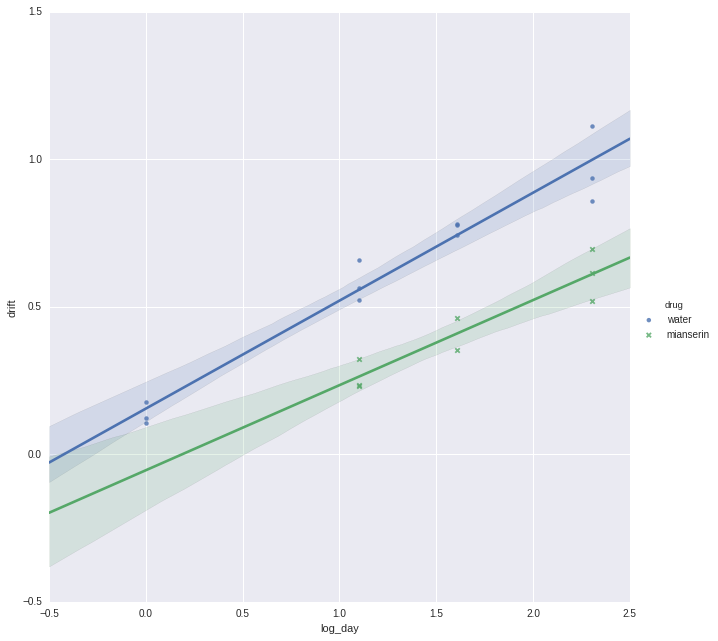

In [24]:
sns.lmplot(
    data = drift.query("cohort <= 7 & samples != 62"),
    x = "log_day", y = "drift",
    hue = "drug", size = 9, markers = ['o', 'x']
);

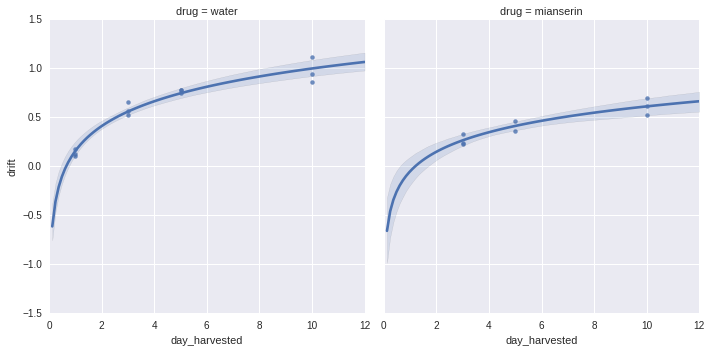

In [25]:
sns.lmplot(
    data = drift.query("cohort <= 7 & samples != 62"),
    x = "day_harvested", y = "drift",
    col = "drug", logx = True
);

### Pearson coefficients

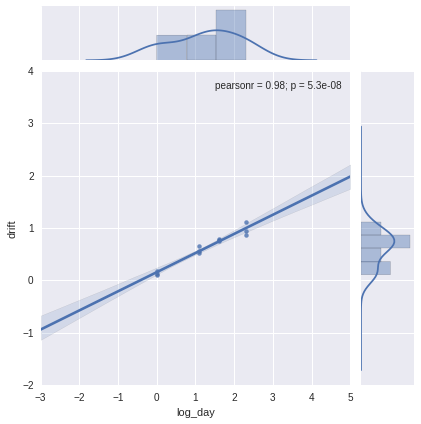

In [26]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'water'"),
    x = "log_day", y = "drift",
    kind = "reg"
);

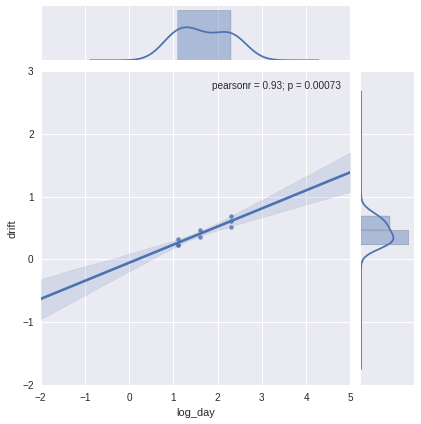

In [27]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'mianserin'"),
    x = "log_day", y = "drift",
    kind = "reg"
);

### Residuals

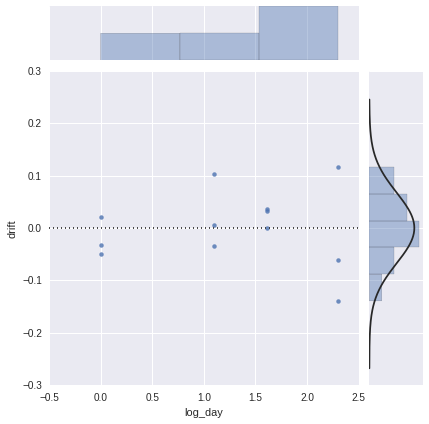

In [28]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'water'"),
    x = "log_day", y = "drift",
    kind = "resid"
);

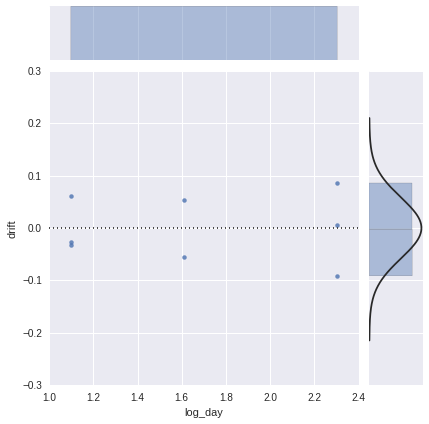

In [29]:
sns.jointplot(
    data = drift.query("cohort <= 7 & samples != 62 & drug == 'mianserin'"),
    x = "log_day", y = "drift",
    kind = "resid"
);

The residuals for mianserin with a log linear model look more like random variation (symmetric about zero). The model may still be a bit off for the water data though.

### Polynomial model

/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


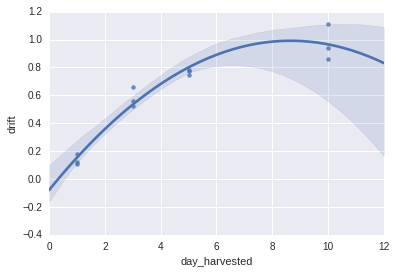

In [30]:
sns.regplot(
    data = drift.query("drug == 'water'"),
    x = "day_harvested", y = "drift",
    order = 2
);

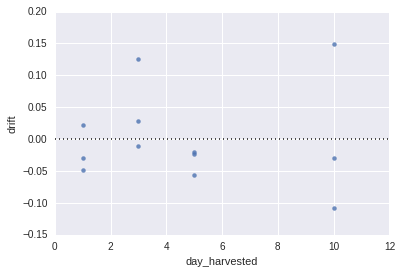

In [31]:
sns.residplot(
    data = drift.query("drug == 'water'"),
    x = "day_harvested", y = "drift",
    order = 2
);

The residuals don't look as good as the log linear model.

## Conclusion

The dataset does indeed tend to drift over time. Specifically it seems that drift increases with the log of time. Mianserin treated worms look like they drift at the rate as control worms, but have less overall drift at each measured time point.